In [1]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import keras
import gc
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from itertools import permutations
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.utils import np_utils, multi_gpu_model, plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, concatenate, Reshape, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Conv1D, MaxPool1D, UpSampling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from skimage.measure import compare_ssim as ssim

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import keras.backend as K
from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Load Dataset
dataset = np.load('/content/gdrive/My Drive/DL/dataset_2_char_cat_45000_15000_140.npy')
print(dataset.shape)

(60000, 14001)


In [4]:
# Train, Test Split
# Train: for CAE Learning + Detection Thresholding
# Test: only for Validation
X, Y = dataset[:, 1:], dataset[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(42000, 14000) (42000,)
(18000, 14000) (18000,)


In [0]:
Y_train_cat, Y_test_cat = np_utils.to_categorical(Y_train), np_utils.to_categorical(Y_test)

In [6]:
#Call Models
cnn_model = load_model('/content/gdrive/My Drive/DL/cnn.h5')
cae_model = load_model('/content/gdrive/My Drive/DL/cae.h5')
classifier_model = load_model('/content/gdrive/My Drive/DL/classifier.h5')
densenet = load_model('/content/gdrive/My Drive/DL/densenet.h5')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
# Lock Weight
for i, l in enumerate(cae_model.layers):
    l.trainable = False
    l.name = 'cae_'+str(i)
cae_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cae_0 (InputLayer)           (None, 14000)             0         
_________________________________________________________________
cae_1 (Reshape)              (None, 100, 140, 1)       0         
_________________________________________________________________
cae_2 (Conv2D)               (None, 100, 140, 32)      160       
_________________________________________________________________
cae_3 (MaxPooling2D)         (None, 50, 70, 32)        0         
_________________________________________________________________
cae_4 (Conv2D)               (None, 50, 70, 32)        4128      
_________________________________________________________________
cae_5 (MaxPooling2D)         (None, 25, 35, 32)        0         
_________________________________________________________________
cae_6 (Conv2D)               (None, 25, 35, 32)        4128

In [0]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    
    # BN --> ReLu --> Bottleneck (1X1) Conv --> (3X3) Conv --> Dropout : 얘네를 모아서(Concat해서) dense block 을 만든다

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=3, name=conv_name_base+'_x1_bn')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=3, name=conv_name_base+'_x2_bn')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [0]:
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, 
                dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    
    #Conv Block 들을 Concat 해주는 역할
   
    #grow_nb_filters: flag to decide to allow number of filters to grow

    eps = 1.1e-5
    
    # concat 할 대상
    concat_feat = x
    
    #for loop 을 layer 개수만큼 돌면서 concat
    #filter 를 growth rate 만큼 늘려가면서 concat 한다
    #Stage 와 branch 는 그냥 index
    
    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = keras.layers.concatenate([concat_feat, x], name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

In [0]:
def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    
    #BN 에 필요한 constant 
    eps = 1.1e-5
    
    #이름붙이기
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 
    
    #Transition Block 의 Sequence : BN --> ReLu --> Conv(1,1)
    x = BatchNormalization(epsilon=eps, axis=3, name=conv_name_base+'_bn')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x

In [0]:
def DenseNet(nb_dense_block=4, growth_rate=48, nb_filter=96, reduction=0.0, 
             dropout_rate=0.0, weight_decay=1e-4, classes=2):

         
    eps = 1.1e-5

    # Transition Block 을 통과하며 줄어드는 차원 비율
    compression = 1.0 - reduction
    
    # 논문 기준 filter 수
    #nb_filter = 96
    nb_layers = [6,12,36,24] # For DenseNet-161

    # Initial Convolution
    # Reshape --> ZeroPadding --> Conv --> BN --> ReLu --> ZeroPadding --> MaxPooling
    cae_output = cae_model.get_layer('cae_12').output
    x = Reshape((100, 140, 1))(cae_output)
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(x)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=3, name='conv1_bn')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Dense Block 추가
    # Dense Block = Conv_Block 을 Concat 한 것
    # (Bottleneck layer) BN -> ReLu --> Conv(1,1) --> Dropout  --> (3x3 Convolution) BN --> ReLu --> Zeropadding(1,1) --> Conv2D(3,3) --> Dropout

    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, 
                                   growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Transition Block 추가
        x = transition_block(x, stage, nb_filter, compression=compression, 
                             dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, 
                               growth_rate, dropout_rate=dropout_rate, 
                               weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=3, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    
    #GAP는 파라미터 수를 줄여 오버피팅을 방지하는 기능
    x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

    x = Dense(classes, name='fc6')(x)
    x = Activation('softmax', name='prob')(x)

    model = Model(cae_model.input, x, name='densenet')

    return model

In [0]:
densenet = DenseNet(nb_dense_block=2, growth_rate=2, nb_filter=96, reduction=0.5, dropout_rate=0.5, weight_decay=1e-4, classes=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (7, 7), name="conv1", strides=(2, 2), use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), name="conv2_1_x1", use_bias=False)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (3, 3), name="conv2_1_x2", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), name="conv2_2_x1", use_bias=False)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (3, 3), name="conv2_2_x2", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher

In [97]:
densenet.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cae_0 (InputLayer)              (None, 14000)        0                                            
__________________________________________________________________________________________________
cae_1 (Reshape)                 (None, 100, 140, 1)  0           cae_0[0][0]                      
__________________________________________________________________________________________________
cae_2 (Conv2D)                  (None, 100, 140, 32) 160         cae_1[0][0]                      
__________________________________________________________________________________________________
cae_3 (MaxPooling2D)            (None, 50, 70, 32)   0           cae_2[0][0]                      
___________________________________________________________________________________________

In [0]:
from keras import optimizers
adam = Adam(lr = 1e-04)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
densenet.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights = True)

In [0]:
%%time
history_densenet = densenet.fit(X_train, Y_train_cat, validation_data=(X_test, Y_test_cat), 
                                                epochs=200, batch_size=32, verbose=2, callbacks = [es])

Train on 42000 samples, validate on 18000 samples
Epoch 1/200


In [0]:
densenet.save('/content/gdrive/My Drive/DL/densenet.h5')

In [0]:
Y_test_hat_ours = densenet.predict(X_test)
Y_test_hat_cnn = cnn_model.predict(X_test)

In [0]:
print(confusion_matrix(Y_test, np.argmax(Y_test_hat_ours, axis=1)))
print(confusion_matrix(Y_test, np.argmax(Y_test_hat_cnn, axis=1)))
print(classification_report(Y_test, np.argmax(Y_test_hat_ours, axis=1)))
print(classification_report(Y_test, np.argmax(Y_test_hat_cnn, axis=1)))

[[13173   373]
 [  544  3910]]
[[13226   320]
 [  662  3792]]
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13546
         1.0       0.91      0.88      0.90      4454

    accuracy                           0.95     18000
   macro avg       0.94      0.93      0.93     18000
weighted avg       0.95      0.95      0.95     18000

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     13546
         1.0       0.92      0.85      0.89      4454

    accuracy                           0.95     18000
   macro avg       0.94      0.91      0.92     18000
weighted avg       0.94      0.95      0.94     18000



In [0]:
#Experiment Session

In [0]:
import random

def imbalance_gen(ratio):
  #X_test, Y_test 합치기
  stacked = np.hstack((Y_test.reshape(18000,1),X_test))

  #정상, 비정상 분류
  benigns = stacked[stacked[:, 0] == 0]
  phishs = stacked[stacked[:, 0] == 1]

  #생성된 데이터가 들어갈 자리 만들기
  X_gen = np.zeros((int(np.sum(Y_test)), X_test.shape[1]))
  Y_gen = np.zeros((int(np.sum(Y_test)),))


  #정상개수, 비정상개수
  num_benign = int(round(np.sum(Y_test) * (1 - ratio)))
  num_phish = int(np.sum(Y_test)) - num_benign

  #정상, 비정상 인덱스 리스트
  random_idxs_benign = np.arange(0, benigns.shape[0], 1).tolist()
  random_idxs_phish = np.arange(0, phishs.shape[0] ,1).tolist()

  #정상고르기
  for i in range(num_benign):
    random_idx_benign = random.choice(random_idxs_benign)
    X_gen[i,:] = benigns[random_idx_benign, 1:]
    Y_gen[i] = benigns[random_idx_benign, 0]

  #비정상고르기
  for i in range(num_benign, num_benign + num_phish, 1):
    random_idx_phish = random.choice(random_idxs_phish)
    X_gen[i,:] = phishs[random_idx_phish, 1:]
    Y_gen[i] = phishs[random_idx_phish, 0]
  return X_gen, Y_gen

In [0]:
#실험 1.Noise robustness test

def noise_robustness(model1,model2,factor,strength):
  
  #Our Results
  recalls_ours = []
  precisions_ours = []
  accuracies_ours = []
  fallouts_ours = []
  
  #CNN Results
  recalls_cnn = []
  precisions_cnn = []
  accuracies_cnn = []
  fallouts_cnn = []
  
  for str in strength:
    noise = factor * np.random.normal(loc = 0, scale = 1 + str, size=(X_test.shape[0], X_test.shape[1]))
    
    y_hat_ours = model1.predict(X_test + noise)
    y_hat_cnn = model2.predict(X_test + noise)
    
    conf_mat_ours = confusion_matrix(Y_test, np.argmax(y_hat_ours, axis = 1))
    conf_mat_cnn = confusion_matrix(Y_test, np.argmax(y_hat_cnn, axis = 1))
    
    recall_ours = conf_mat_ours[1,1]/ np.sum(conf_mat_ours[1,:])
    precision_ours = conf_mat_ours[0,0]/ np.sum(conf_mat_ours[0,:])
    accuracy_ours = (conf_mat_ours[0,0] + conf_mat_ours[1,1])/ np.sum(conf_mat_ours)
    fallout_ours = (conf_mat_ours[0,1]) / np.sum(conf_mat_ours[0,:])
                                            
    recalls_ours.append(recall_ours)
    precisions_ours.append(precision_ours)
    accuracies_ours.append(accuracy_ours)
    fallouts_ours.append(fallout_ours)
                                            
    recall_cnn = conf_mat_cnn[1,1]/ np.sum(conf_mat_cnn[1,:])
    precision_cnn = conf_mat_cnn[0,0]/ np.sum(conf_mat_cnn[0,:])
    accuracy_cnn = (conf_mat_cnn[0,0] + conf_mat_cnn[1,1])/ np.sum(conf_mat_cnn)
    fallout_cnn = (conf_mat_cnn[0,1]) / np.sum(conf_mat_cnn[0,:])
                                           
    recalls_cnn.append(recall_cnn)
    precisions_cnn.append(precision_cnn)
    accuracies_cnn.append(accuracy_cnn)
    fallouts_cnn.append(fallout_cnn)
    
  return recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn

In [0]:
%%time
t = [0,0.05,0.1,0.15,0.2]
recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn = noise_robustness(densenet, cnn_model, 0.01, t)


CPU times: user 2min 21s, sys: 37.5 s, total: 2min 59s
Wall time: 3min 49s


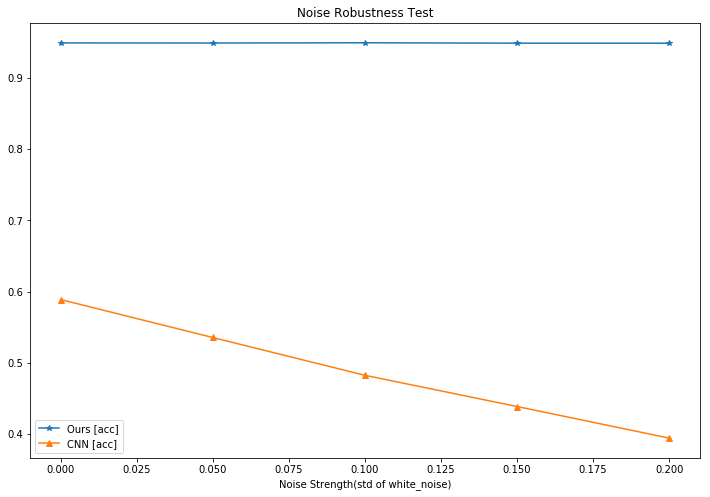

In [0]:
plt.figure(figsize = (12,8))
plt.title('Noise Robustness Test')
#plt.plot(t,recalls_ours, label = 'Ours [recall]', marker = 'o')
#plt.plot(t,recalls_cnn, label = 'CNN [recall]', marker = 's')
plt.plot(t,accuracies_ours, label = 'Ours [acc]', marker = '*')
plt.plot(t,accuracies_cnn, label = 'CNN [acc]', marker = '^')
plt.xlabel('Noise Strength(std of white_noise)')
plt.legend()

In [0]:
# 실험 2. Zero day attack robustness test

def imbalance_robustness(model1, model2, ratios):
  #Our Results
  recalls_ours = []
  precisions_ours = []
  accuracies_ours = []
  fallouts_ours = []
  
  #CNN Results
  recalls_cnn = []
  precisions_cnn = []
  accuracies_cnn = []
  fallouts_cnn = []
  
  for ratio in ratios:
    X_gen, Y_gen = imbalance_gen(ratio = ratio)
    
    y_hat_ours = model1.predict(X_gen)
    y_hat_cnn = model2.predict(X_gen)
    
    conf_mat_ours = confusion_matrix(Y_gen, np.argmax(y_hat_ours, axis = 1))
    conf_mat_cnn = confusion_matrix(Y_gen, np.argmax(y_hat_cnn, axis = 1))
    
    recall_ours = conf_mat_ours[1,1]/ np.sum(conf_mat_ours[1,:])
    precision_ours = conf_mat_ours[0,0]/ np.sum(conf_mat_ours[0,:])
    accuracy_ours = (conf_mat_ours[0,0] + conf_mat_ours[1,1])/ np.sum(conf_mat_ours)
    fallout_ours = (conf_mat_ours[0,1]) / np.sum(conf_mat_ours[0,:])
                                            
    recalls_ours.append(recall_ours)
    precisions_ours.append(precision_ours)
    accuracies_ours.append(accuracy_ours)
    fallouts_ours.append(fallout_ours)
                                            
    recall_cnn = conf_mat_cnn[1,1]/ np.sum(conf_mat_cnn[1,:])
    precision_cnn = conf_mat_cnn[0,0]/ np.sum(conf_mat_cnn[0,:])
    accuracy_cnn = (conf_mat_cnn[0,0] + conf_mat_cnn[1,1])/ np.sum(conf_mat_cnn)
    fallout_cnn = (conf_mat_cnn[0,1]) / np.sum(conf_mat_cnn[0,:])
                                           
    recalls_cnn.append(recall_cnn)
    precisions_cnn.append(precision_cnn)
    accuracies_cnn.append(accuracy_cnn)
    fallouts_cnn.append(fallout_cnn)
    
  return recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn

In [0]:
%%time
t =  [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
recalls_ours ,precisions_ours,accuracies_ours, fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn = imbalance_robustness(densenet, cnn_model,t)

CPU times: user 50.6 s, sys: 23.3 s, total: 1min 13s
Wall time: 1min 36s


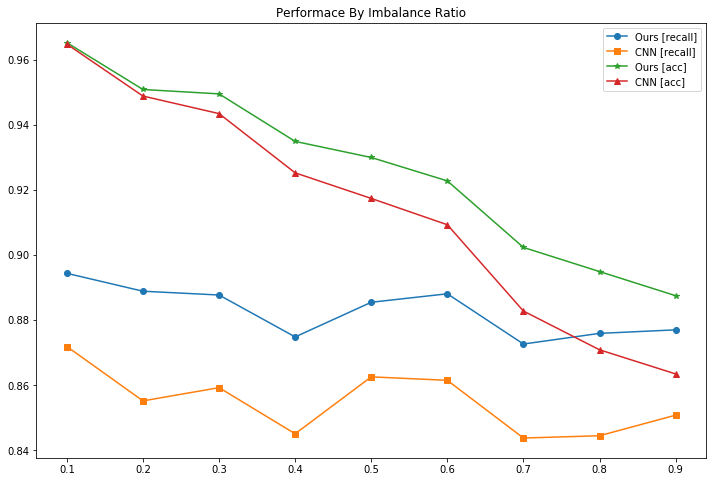

In [0]:
plt.figure(figsize = (12,8))
plt.title('Performace By Imbalance Ratio')
plt.plot(t,recalls_ours, label = 'Ours [recall]', marker = 'o')
plt.plot(t,recalls_cnn, label = 'CNN [recall]', marker = 's')
plt.plot(t,accuracies_ours, label = 'Ours [acc]', marker = '*')
plt.plot(t,accuracies_cnn, label = 'CNN [acc]', marker = '^')
plt.legend()

In [0]:
# Gradient Fingerprint Exp.

In [0]:
def get_gradients(model):
    """Return the gradient of every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    Next, get the gradients of the loss with respect to the weights.

    """
    weights = [tensor for tensor in model.trainable_weights]
    optimizer = model.optimizer

    return optimizer.get_gradients(model.total_loss, weights)

In [34]:
get_gradients(densenet)

[<tf.Tensor 'gradients_2/conv1_2/convolution_grad/Conv2DBackpropFilter:0' shape=(7, 7, 1, 96) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_249:0' shape=(96,) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_250:0' shape=(96,) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_246:0' shape=(96,) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_247:0' shape=(96,) dtype=float32>,
 <tf.Tensor 'gradients_2/conv2_1_x1_2/convolution_grad/Conv2DBackpropFilter:0' shape=(1, 1, 96, 16) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_242:0' shape=(16,) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_243:0' shape=(16,) dtype=float32>,
 <tf.Tensor 'gradients_2/conv2_1_x2_2/convolution_grad/Conv2DBackpropFilter:0' shape=(3, 3, 16, 4) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_238:0' shape=(100,) dtype=float32>,
 <tf.Tensor 'gradients_2/AddN_239:0' shape=(100,) dtype=float32>,
 <tf.Tensor 'gradients_2/conv2_2_x1_2/convolution_grad/Conv2DBackpropFilter:0' shape=(1, 1, 100, 16) dtype=float32>,
 <tf.Tensor 'gradien

In [0]:
weights = densenet.trainable_weights 

gradients = densenet.optimizer.get_gradients(densenet.total_loss, weights)
import keras.backend as K

input_tensors = [
                 densenet.inputs[0], 
                 densenet.sample_weights[0], 
                 densenet.targets[0], 
                 K.learning_phase(), 
]

get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [0]:
inputs = [
    [X_test[0]], # X
          [0.00005], # sample weights
          Y_test[0], # y
          0 # learning phase in TEST mode
]
grad = get_gradients(inputs)

In [50]:
output_tens = densenet.layers[-1].output
input_tens = densenet.layers[0].input

grad = tf.gradients(output_tens, input_tens)
sess= tf.Session()
sess.run(grad, feed_dict={input_tens: X_test[0].reshape(1,-1)})

FailedPreconditionError: ignored

In [48]:
X_test.shape, densenet.layers[0].input

((18000, 14000),
 <tf.Tensor 'cae_0_1:0' shape=(?, 14000) dtype=float32>,
 array([[0., 0., 0., ..., 0., 0., 0.]]))

In [102]:
gradients = []
for i,layer in enumerate(densenet.layers):
  print(i)
  if layer.trainable == True:
    if densenet.layers[i].get_weights() != []:
      grad = densenet.optimizer.get_gradients(densenet.total_loss, densenet.layers[i].get_weights()[0])
      gradients.append(grad)
      print(grad)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


ValueError: ignored

In [0]:
gradients = K.gradients(densenet.output, densenet.input)              #Gradient of output wrt the input of the model (Tensor)
print(gradients)

#value of gradient for the first x_test
x_test_1 = X_test[0].reshape([1,-1])
sess = tf.Session()
evaluated_gradients_1 = sess.run(gradients[0], feed_dict={densenet.input: 
x_test_1})

[<tf.Tensor 'gradients_17/cae_1_1/Reshape_grad/Reshape:0' shape=(?, 14000) dtype=float32>]


FailedPreconditionError: ignored

In [0]:
def get_weight_grad(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad


def get_layer_output_grad(model, inputs, outputs, layer=-1):
    """ Gets gradient a layer output for given inputs and outputs"""
    grads = model.optimizer.get_gradients(model.total_loss, model.layers[layer].output)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad

ValueError: ignored

In [0]:
(densenet.inputs+ densenet.targets + densenet.sample_weights)

[<tf.Tensor 'cae_0_1:0' shape=(?, 14000) dtype=float32>,
 <tf.Tensor 'prob_target:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'prob_sample_weights:0' shape=(?,) dtype=float32>]

In [54]:
densenet.sample_weights

[<tf.Tensor 'prob_sample_weights:0' shape=(?,) dtype=float32>]

In [85]:
#sess = tf.keras.backend.get_session(densenet.trainable_weights)
sess= tf.Session()
sess.run(densenet.optimizer.get_gradients(densenet.loss(Y_train, densenet.predict(X_train), densenet.trainable_variables)))

CancelledError: ignored